In [20]:
import seaborn as sns, pandas as pd, numpy as np
from sklearn.svm import OneClassSVM, SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, ParameterGrid, KFold, GridSearchCV, train_test_split, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_fscore_support
import matplotlib.lines as mlines
import plotly.express as px
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.inspection import permutation_importance

data = pd.read_csv('./results/features_df.csv')
data

,Corpus,Type,Avg Word Length,Avg Sentence Length,TTR,MATTR,MTLD,Morpheme TTR,Avg Segs Per Word,Avg Forms Per Stem,Char Dist Entr,Word Dist Entr,Text Entr,Lex Entr,Rev Lex Entr
0,eo,con,5.175,18.909,10.708,0.692,67.482,0.075,1.859,3.506,4.164,10.923,4.435,6.189,6.919
1,nl,nat,5.419,18.194,8.559,0.694,74.165,0.125,1.809,3.044,4.117,10.593,4.389,6.379,6.814
2,is,nat,5.375,15.055,11.727,0.747,115.342,0.098,1.931,4.128,4.468,11.512,5.455,6.087,6.460
3,pl,nat,6.248,14.951,14.890,0.825,278.888,0.066,1.894,3.709,4.553,12.905,5.072,5.605,5.654
4,fr,nat,5.160,23.120,7.461,0.721,91.865,0.071,1.771,2.759,4.179,10.711,4.104,6.305,6.742
5,vo,con,5.072,11.266,2.455,0.622,39.447,0.153,1.567,1.938,4.256,7.666,1.281,8.627,8.958
6,af,nat,5.067,20.496,6.987,0.645,59.938,0.139,1.770,2.861,4.072,9.993,4.757,6.656,7.117
7,vi,nat,3.498,29.835,1.749,0.732,94.751,0.274,1.344,1.453,4.855,9.717,4.768,11.864,11.481
8,oc,nat,5.215,18.660,7.185,0.715,87.187,0.077,1.793,2.805,4.173,10.546,3.530,6.654,7.224
9,en,nat,5.087,21.301,6.079,0.697,77.659,0.100,1.661,2.360,4.167,10.673,4.771,7.097,7.500


## Anomaly Detection

### One Class SVM

In [2]:
# OCSVM Finetuning
# Brute force approach (ParameterGrid)
# gamma defines how much influence a single training sample has. Smaller value means a larger radius of influence for each sample, and vice versa
# usually between γ∈[10^−6,10^0] used for the RBF kernel; common initial guesses around γ∈[0.001,1]
# nu is the upper bound on the fraction of training errors and a lower bound of support vectors. Controls proportion of outliers allowed
# usually between 0 and 1; common initial ranges around ν∈[0.01,0.5]

X, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'con':-1, 'nat':1}).values
scaler = StandardScaler()
# Train on target == 'nat' (natural languages)
X_train = scaler.fit_transform(X[y == 1])
X_test = scaler.transform(X)

param_grid = {
    'gamma': [0.000001, 0.0001, 0.001, 0.01, 0.1, 1],
    'nu': [0.01, 0.05, 0.1, 0.2, 0.25, 0.5]
}

grid = ParameterGrid(param_grid)
results = []
for params in grid:
    ocsvm = OneClassSVM(kernel='rbf', gamma=params['gamma'], nu=params['nu'])
    ocsvm.fit(X_train)
    y_pred = ocsvm.predict(X_test)
    predicted_types = np.where(y_pred == 1, 'nat', 'con')
    precision = precision_score(data['Type'], predicted_types, pos_label='con')
    recall = recall_score(data['Type'], predicted_types, pos_label='con')
    f1 = f1_score(data['Type'], predicted_types, pos_label='con')
    
    results.append({
        'gamma': params['gamma'],
        'nu': params['nu'],
        'precision': precision,
        'recall': recall,
        'f1': f1
    })
    
ocsvm_parameter_search_results_df = pd.DataFrame(results)
ocsvm_parameter_search_results_df.to_csv('./results/ocsvm_parameter_search_results_df.csv')
best_params = ocsvm_parameter_search_results_df.sort_values(by='f1', ascending=False).iloc[0]
print(f"Best Params: Gamma={best_params['gamma']}, Nu={best_params['nu']}")
print(best_params)

Best Params: Gamma=0.01, Nu=0.1
gamma        0.010000
nu           0.100000
precision    0.833333
recall       0.833333
f1           0.833333
Name: 20, dtype: float64


[LibSVM]*
optimization finished, #iter = 7
obj = 0.234709, rho = 0.521592
nSV = 3, nBSV = 0
{'eo': 0.5588892136581479, 'nl': 0.5692346649935943, 'is': 0.544877415659641, 'pl': 0.5429384050538085, 'fr': 0.5487669215156405, 'vo': 0.27938272870772834, 'af': 0.5497432866332218, 'vi': 0.5214907316478975, 'oc': 0.5315918897508111, 'en': 0.5651839434455173, 'it': 0.5447021542392415, 'ia': 0.5076687360727405, 'sv': 0.5716454054166626, 'lfn': 0.49261043859475667, 'da': 0.5685749816335364, 'hu': 0.5313690964415092, 'id': 0.5518720225513458, 'tl': 0.5216428629564647, 'tr': 0.5492766625527343, 'io': 0.27280029990931604, 'es': 0.5258874804805129, 'fi': 0.5216428807993918, 'de': 0.5581925225107022, 'avk': 0.4931716016218649}
{'eo': 'nat', 'nl': 'nat', 'is': 'nat', 'pl': 'nat', 'fr': 'nat', 'vo': 'con', 'af': 'nat', 'vi': 'con', 'oc': 'nat', 'en': 'nat', 'it': 'nat', 'ia': 'con', 'sv': 'nat', 'lfn': 'con', 'da': 'nat', 'hu': 'nat', 'id': 'nat', 'tl': 'nat', 'tr': 'nat', 'io': 'con', 'es': 'nat', 'fi'

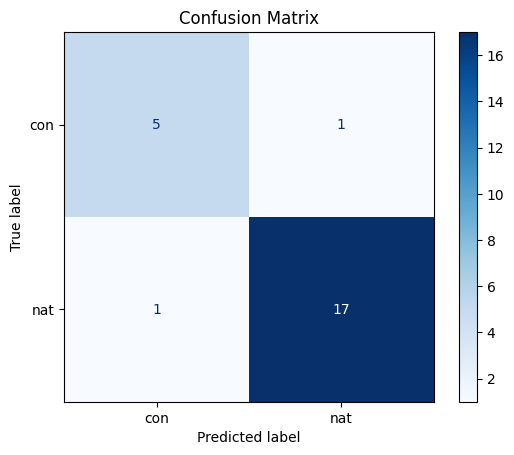

In [3]:
# OCSVM with Finetuned Hyperparams

X, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'con':-1, 'nat':1}).values
scaler = StandardScaler()
# Train on target == 'nat' (natural languages)
X_train = scaler.fit_transform(X[y == 1])
X_test = scaler.transform(X)

best_ocsvm = OneClassSVM(kernel='rbf', gamma=0.01, nu=0.05, verbose=True)
best_ocsvm.fit(X_train)

y_pred = best_ocsvm.predict(X_test)
scores = best_ocsvm.score_samples(X_test)
print({lang: pred for lang, pred in zip(data['Corpus'], scores)})

predicted_types = np.where(y_pred == 1, 'nat', 'con')
print({lang: pred for lang, pred in zip(data['Corpus'], predicted_types)})

# Model performance report 
report = classification_report(data['Type'], predicted_types, target_names=['con', 'nat'], output_dict=True)
report.update({"accuracy": {"precision": None, "recall": None, "f1-score": report["accuracy"], "support": report['macro avg']['support']}})
ocsvm_with_finetuning_report = pd.DataFrame(report).transpose()
ocsvm_with_finetuning_report.to_csv('./results/ocsvm_with_finetuning_report.csv')

# Confusion Matrix
matrix_df = pd.DataFrame({
    'Corpus': data['Corpus'],
    'True': data['Type'],
    'Predicted': predicted_types
})
conf_matrix = confusion_matrix(matrix_df['True'], matrix_df['Predicted'], labels=['con', 'nat'])
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['con', 'nat'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

One-Class SVM Visualization (Decision Boundary)

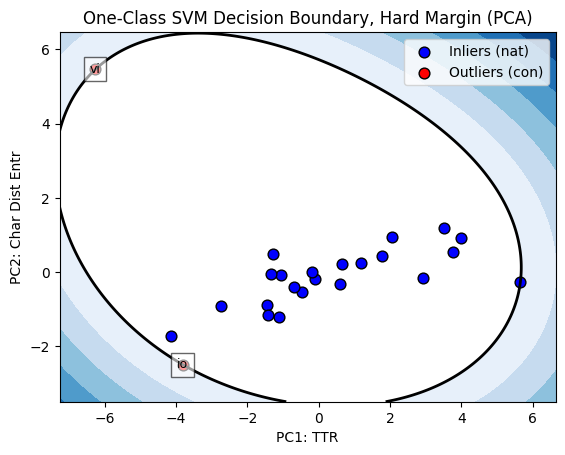

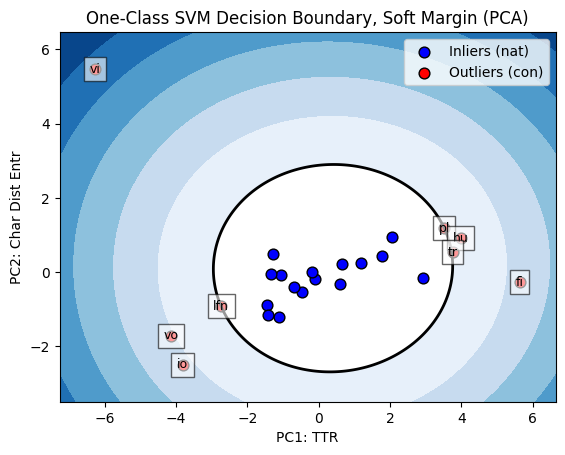

In [4]:
# Plot decision function of finetuned One-Class SVM (visualization in 2D space)
# How can I interpret the decision function? Should I visualize the decision boundary differently?

X, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'con':-1, 'nat':1}).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Find PC1 and PC2
components_df = pd.DataFrame(pca.components_, columns=data.select_dtypes(include='number').columns, index=['PC1', 'PC2'])
def get_top_features(components_df, pc_name, top_n=1):
    pc_loadings = components_df.loc[pc_name]
    top_features = pc_loadings.abs().nlargest(top_n).index
    return top_features.tolist()

# Hard Margin OCSVM
# Has 2 outliers at n=0.05
hard_ocsvm = OneClassSVM(kernel='rbf', gamma=0.01, nu=0.05)
hard_ocsvm.fit(X_pca)

# Predict the decision function (distance to the decision boundary)
hard_decision_function = hard_ocsvm.decision_function(X_pca)
hard_pred = hard_ocsvm.predict(X_pca)

# Plot decision boundary and margins
xx, yy = np.meshgrid(np.linspace(X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1, 500),
                     np.linspace(X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1, 500))

Z = hard_ocsvm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision function as a contour plot
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='white')

plt.scatter(X_pca[hard_pred == 1][:, 0], X_pca[hard_pred == 1][:, 1], 
            c='blue', label='Inliers (nat)', edgecolors='k', s=60)
plt.scatter(X_pca[hard_pred == -1][:, 0], X_pca[hard_pred == -1][:, 1], 
            c='red', label='Outliers (con)', edgecolors='k', s=60)

for i, corpus_value in enumerate(data['Corpus'].values):
    if hard_pred[i] == -1: 
        plt.annotate(
            corpus_value, 
            (X_pca[i, 0], X_pca[i, 1]), 
            textcoords="offset points", xytext=(0, 0), 
            ha='center', va='center',  
            fontsize=9, color='black',
            bbox=dict(facecolor='white', alpha=0.6)  
        )

plt.title('One-Class SVM Decision Boundary, Hard Margin (PCA)')
plt.xlabel(f"PC1: {get_top_features(components_df, 'PC1')[0]}")
plt.ylabel(f"PC2: {get_top_features(components_df, 'PC2')[0]}")
plt.legend()
plt.show()

# Soft Margin OCSVM
# Has 8 outliers at n=0.3
soft_ocsvm = OneClassSVM(kernel='rbf', gamma=0.01, nu=0.3)
soft_ocsvm.fit(X_pca)

# Predict the decision function (distance to the decision boundary)
soft_decision_function = soft_ocsvm.decision_function(X_pca)
soft_pred = soft_ocsvm.predict(X_pca)

# Plot decision boundary and margins
xx, yy = np.meshgrid(np.linspace(X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1, 500),
                     np.linspace(X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1, 500))

Z = soft_ocsvm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision function as a contour plot
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='white')

plt.scatter(X_pca[soft_pred == 1][:, 0], X_pca[soft_pred == 1][:, 1], 
            c='blue', label='Inliers (nat)', edgecolors='k', s=60)
plt.scatter(X_pca[soft_pred == -1][:, 0], X_pca[soft_pred == -1][:, 1], 
            c='red', label='Outliers (con)', edgecolors='k', s=60)

for i, corpus_value in enumerate(data['Corpus'].values):
    if soft_pred[i] == -1: 
        plt.annotate(
            corpus_value, 
            (X_pca[i, 0], X_pca[i, 1]), 
            textcoords="offset points", xytext=(0, 0), 
            ha='center', va='center',  
            fontsize=9, color='black',
            bbox=dict(facecolor='white', alpha=0.6)  
        )

plt.title('One-Class SVM Decision Boundary, Soft Margin (PCA)')
plt.xlabel(f"PC1: {get_top_features(components_df, 'PC1')[0]}")
plt.ylabel(f"PC2: {get_top_features(components_df, 'PC2')[0]}")
plt.legend()
plt.show()

### Isolation Forest

In [2]:
n_components = 3
pca = PCA(n_components=n_components)
components = pca.fit_transform(data.iloc[:,2:].values.round(decimals=3))

total_var = pca.explained_variance_ratio_.sum() * 100

labels = {str(i): f"PC {i+1}" for i in range(n_components)}
labels['color'] = 'Type'

fig = px.scatter_matrix(
    components,
    color=data['Type'],
    dimensions=range(n_components),
    labels=labels,
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)
fig.show()

/usr/local/lib/python3.9/site-packages/sklearn/ensemble/_iforest.py:308: UserWarning:

max_samples (100) is greater than the total number of samples (24). max_samples will be set to n_samples for estimation.

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.2s remaining:    1.2s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.3s finished


Number of outliers detected: -6
Number of inliers detected: 18
(0.5555555555555556, 0.5555555555555556, 0.5555555555555556, None)


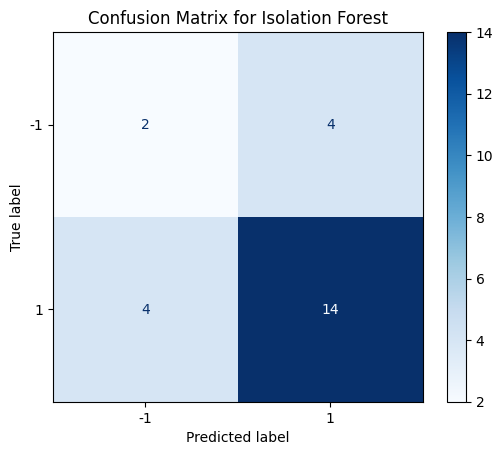

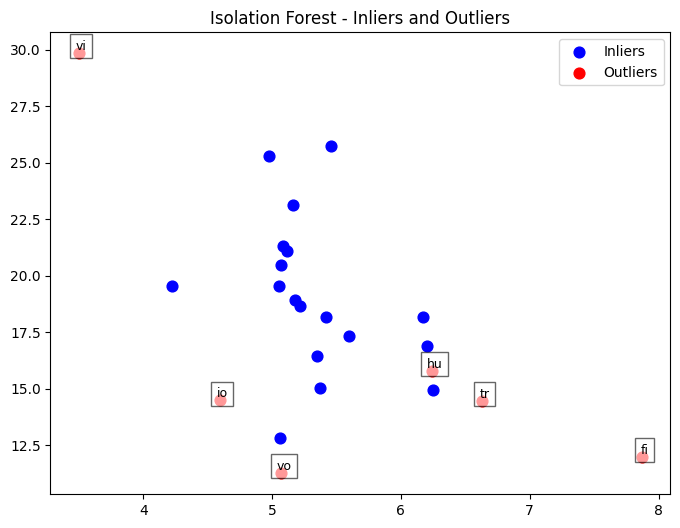

In [11]:
# Isolation Forest with Finetuning

X, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'con':-1, 'nat':1}).values
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_samples': 'auto',
# }

# outlier_fraction = len(np.where(y==0)[0])/len(np.where(y==1)[0])
ifc = IsolationForest(max_samples=100,
                      random_state=42,
                      contamination=0.25,
                      max_features=1.0,
                      n_estimators=100,
                      verbose=1,
                      n_jobs=-1)

ifc.fit(X)
y_pred = ifc.predict(X)
y_pred_adjusted = [-1 if x == -1 else 1 for x in y_pred]

# scorer = make_scorer(f1_score(average='micro'))

# grid_search = GridSearchCV(estimator=ifc, param_grid=param_grid, scoring=scorer, cv=3, verbose=1)
# grid_search.fit(X_scaled)

# print(grid_search.best_params_)

# best_ifc = grid_search.best_estimator_

# print(ifc.decision_function(X_scaled))
# ifc.fit(X_scaled)
# y_pred = ifc.fit_predict(X_scaled)
# predicted_types = ['con' if p == -1 else 'nat' for p in predictions]
print('Number of outliers detected: {}'.format(y_pred[y_pred == -1].sum()))
print('Number of inliers detected: {}'.format(y_pred[y_pred == 1].sum()))

report = precision_recall_fscore_support(y, y_pred_adjusted, average='macro')
print(report)

cm = confusion_matrix(y, y_pred_adjusted)
disp = ConfusionMatrixDisplay(cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Isolation Forest')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(X[y_pred == 1][:, 0], X[y_pred == 1][:, 1], label="Inliers", c='blue', s=60)
plt.scatter(X[y_pred == -1][:, 0], X[y_pred == -1][:, 1], label="Outliers", c='red', s=60)
for i, txt in enumerate(data['Corpus']):
    if y_pred[i] == -1: 
        plt.text(X[i, 0] + 0.02, X[i, 1] + 0.02, txt, fontsize=9, color='black',
                 ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.6))
plt.title("Isolation Forest - Inliers and Outliers")
plt.legend()
plt.show()

In [ ]:
score = ifc.decision_function(X_scaled)
score_df = pd.DataFrame(score, columns=['Decision Function Scores'])
data_scores = pd.concat([data['Corpus'], score_df], axis=1)
display(data_scores)

# # Plot Top 5 Outliers
# top_5_outliers = data_scores.sort_values(by=['Anomaly Score']).head()
# plt.scatter(X_scaled[:,0], X_scaled[:,1])
# plt.scatter(top_5_outliers['X'], top_5_outliers['Y'])
# # for i, txt in enumerate(data['Corpus']):
# #     if y_pred[i] == -1: 
# #         plt.text(X_scaled[i, 0] + 0.02, X_scaled[i, 1] + 0.02, txt, fontsize=9, color='black',
# #                  ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.6))
# plt.title('Top 5 Outliers Identified by Isolation Forest')
# plt.show()

In [9]:
data['predictions'] = ifc.predict(X)
data['predictions'] = np.where(data['predictions']==-1,1,0)

n_components = 3
pca = PCA(n_components=n_components)
components = pca.fit_transform(data.iloc[:,2:].values.round(decimals=3))

total_var = pca.explained_variance_ratio_.sum() * 100

labels = {str(i): f"PC {i+1}" for i in range(n_components)}
labels['color'] = 'Type'

fig = px.scatter_matrix(
    components,
    color=data['predictions'],
    dimensions=range(n_components),
    labels=labels,
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)
fig.show()

### PCA

   Corpus Type  Avg Word Length  Avg Sentence Length     TTR  MATTR     MTLD  \
7      vi  nat            3.498               29.835   1.749  0.732   94.751   
21     fi  nat            7.874               11.969  20.409  0.841  394.346   

    Morpheme TTR  Avg Segs Per Word  Avg Forms Per Stem  Char Dist Entr  \
7          0.274              1.344               1.453           4.855   
21         0.088              2.008               5.037           4.144   

    Word Dist Entr  Text Entr  Lex Entr  Rev Lex Entr  
7            9.717      4.768    11.864        11.481  
21          13.729      4.529     4.919         5.527  


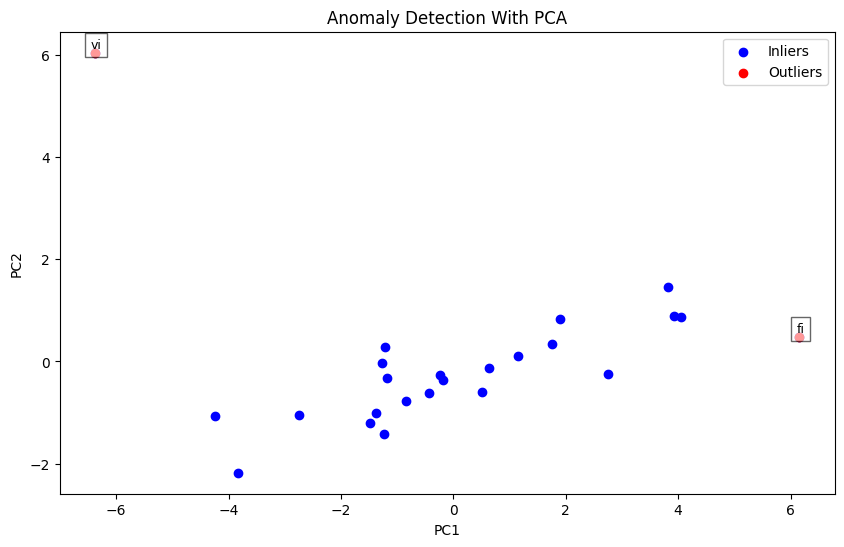

In [25]:
X = data.iloc[:,2:].values.round(decimals=3)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

distances = np.sum(X_pca**2, axis=1)

threshold = np.percentile(distances, 95)

anomalies = distances > threshold

anomaly_indices = np.where(anomalies)[0]
anomaly_data = data.iloc[anomaly_indices]
print(anomaly_data)

plt.figure(figsize=(10,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c='blue', label='Inliers')
plt.scatter(X_pca[anomalies, 0], X_pca[anomalies, 1], c='red', label='Outliers')
for i in anomaly_indices:
    plt.text(X_pca[i, 0] + 0.02, X_pca[i, 1] + 0.02, data['Corpus'].iloc[i], fontsize=9, color='black',
                ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.6))
plt.title('Anomaly Detection With PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.savefig('./results/PCA_Anomaly_detection.png')
plt.show()

## Classification

### Decision Tree

Fitting 24 folds for each of 144 candidates, totalling 3456 fits


/usr/local/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters:  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


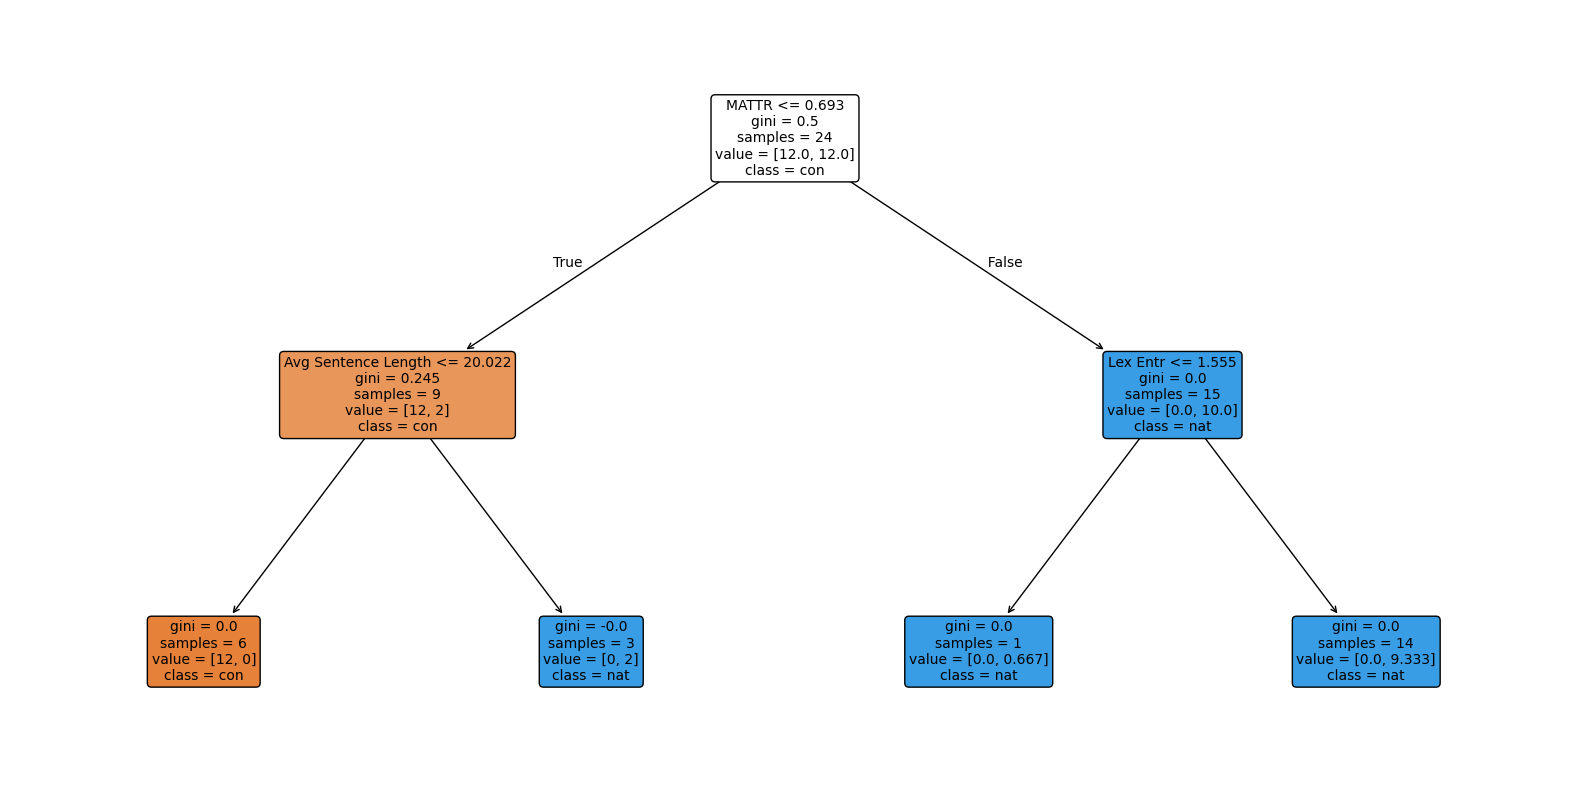

In [2]:
X, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'con':0, 'nat':1}).values

param_grid = {
    'criterion':  ['gini', 'entropy'],
    'max_depth':  [None, 2, 4, 6, 8, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Try using F1 score (due to inbalanced data)
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid,
    cv=LeaveOneOut(),
    scoring='f1_micro',
    verbose=1,
)

grid_search.fit(X, y)
print("Best parameters: ", grid_search.best_params_)

# Best estimator fitted with best parameters
best_tree = grid_search.best_estimator_

plt.figure(figsize=(20, 10))
tree.plot_tree(best_tree, filled=True, feature_names=['Avg Word Length', 'Avg Sentence Length', 'TTR', 'MATTR', 'Morpheme TTR',	'Avg Segs Per Word', 'Avg Forms Per Stem', 'Char Entr', 'Word Entr', 'Text Entr', 'Lex Entr', 'Rev Lex Entr'], class_names=['con', 'nat'], rounded=True, fontsize=10)
plt.savefig('./results/decisiontree.png')
plt.show()

In [12]:
# # Without class_weight='balanced'

# X, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'con':0, 'nat':1}).values

# param_grid = {
#     'criterion':  ['gini', 'entropy'],
#     'max_depth':  [None, 2, 4, 6, 8, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Try using F1 score (due to inbalanced data)
# grid_search = GridSearchCV(
#     estimator=tree.DecisionTreeClassifier(random_state=42),
#     param_grid=param_grid,
#     cv=LeaveOneOut(),
#     scoring='f1_micro',
#     verbose=1,
# )

# grid_search.fit(X, y)
# print("Best parameters: ", grid_search.best_params_)

# # Best estimator fitted with best parameters
# best_tree = grid_search.best_estimator_

# plt.figure(figsize=(20, 10))
# tree.plot_tree(best_tree, filled=True, feature_names=['Avg Word Length', 'Avg Sentence Length', 'TTR', 'MATTR', 'Morpheme TTR',	'Avg Segs Per Word', 'Avg Forms Per Stem', 'Char Entr', 'Word Entr', 'Text Entr', 'Lex Entr', 'Rev Lex Entr'], class_names=['con', 'nat'], rounded=True, fontsize=10)
# plt.show()

### Random Forest

In [15]:
# Using LeaveOneOut Cross-Validation

X, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'con':0, 'nat':1}).values
loo = LeaveOneOut()
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

param_grid = {
    'n_estimators': [5, 10, 15, 20, 50, 100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=loo,
    scoring='f1_micro',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

best_rf = grid_search.best_estimator_

# Store predictions and true labels
y_pred = np.zeros_like(y)
y_true = np.zeros_like(y)

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    best_rf.fit(X_train, y_train)

    y_pred[test_index] = best_rf.predict(X_test)
    y_true[test_index] = y_test
    
report = classification_report(y_true, y_pred, target_names=['con', 'nat'])
print(report)

# Confusion Matrix for Finetuned Random Forest's Performance
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['con', 'nat'], yticklabels=['con', 'nat'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of Finetuned Random Forest')
plt.savefig('./results/RF_predictions_confusion_matrix')
plt.show()

Fitting 24 folds for each of 4320 candidates, totalling 103680 fits


KeyboardInterrupt: 

In [7]:
# Using LeaveOneOut Cross-Validation

X, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'con':0, 'nat':1}).values
loo = LeaveOneOut()
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

param_grid = {
    'n_estimators': [5, 10, 15, 20, 50, 100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=loo,
    scoring='accuracy',
    verbose=1
)

grid_search.fit(X, y)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

best_rf = grid_search.best_estimator_

# output = cross_validate(best_rf, X, y, cv=loo, scoring='accuracy', return_estimator=True)

# for idx, estimator in enumerate(output['estimator']):
#     print("Features sorted by their score for estimator {}:".format(idx))
#     feature_importances = pd.DataFrame(estimator.feature_importances_,
#                                        index=data.columns[2:].values,
#                                        columns=['importance']).sort_values('importance', ascending=False)
#     print(feature_importances)

Fitting 24 folds for each of 432 candidates, totalling 10368 fits


/usr/local/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters:  {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best score:  0.875
Features sorted by their score for estimator 0:
                     importance
MATTR                  0.200938
Word Dist Entr         0.157249
Avg Word Length        0.122036
Text Entr              0.104229
Lex Entr               0.103389
Rev Lex Entr           0.077027
Avg Sentence Length    0.066737
TTR                    0.065556
Avg Forms Per Stem     0.033322
Char Dist Entr         0.030783
Avg Segs Per Word      0.026797
Morpheme TTR           0.011938
Features sorted by their score for estimator 1:
                     importance
MATTR                  0.224523
Word Dist Entr         0.143148
Text Entr              0.112849
Avg Word Length        0.103330
Avg Sentence Length    0.088154
Rev Lex Entr           0.083854
Lex Entr               0.078720
TTR                    0.055624
Char Dist Entr         0.037355
Avg Forms Per Stem     0

In [8]:
# print(output)

{'fit_time': array([0.36296225, 0.34708881, 0.45700121, 0.35178185, 0.32822013,
       0.34021878, 0.31520939, 0.34455609, 0.30265999, 0.35252976,
       0.3280158 , 0.33061409, 0.29552722, 0.33041   , 0.3211391 ,
       0.30350089, 0.29511595, 0.28640795, 0.28849983, 0.29551196,
       0.28835917, 0.29113293, 0.29278016, 0.29152107]), 'score_time': array([0.01933479, 0.03405809, 0.02236986, 0.03094387, 0.02158117,
       0.019912  , 0.01988769, 0.01994801, 0.02018309, 0.0185492 ,
       0.0185051 , 0.01961589, 0.01843381, 0.01856518, 0.02258015,
       0.02071714, 0.01801324, 0.01795292, 0.01858687, 0.01854181,
       0.0176158 , 0.01787806, 0.01952696, 0.01787376]), 'estimator': [RandomForestClassifier(min_samples_leaf=2, n_estimators=300, random_state=42), RandomForestClassifier(min_samples_leaf=2, n_estimators=300, random_state=42), RandomForestClassifier(min_samples_leaf=2, n_estimators=300, random_state=42), RandomForestClassifier(min_samples_leaf=2, n_estimators=300, random_stat

In [ ]:
# feature_list = list(data.iloc[:,2:].columns)
# importances = list(best_rf.feature_importances_)
# rf_important_df = pd.DataFrame()
# rf_important_df['value'], rf_important_df['importances'] = feature_list, importances

                Feature  Gini Importance
3                 MATTR         0.219458
10             Lex Entr         0.117268
9             Text Entr         0.106971
8        Word Dist Entr         0.102417
0       Avg Word Length         0.100882
11         Rev Lex Entr         0.098466
1   Avg Sentence Length         0.079505
2                   TTR         0.061654
7        Char Dist Entr         0.032533
6    Avg Forms Per Stem         0.032494
4          Morpheme TTR         0.026845
5     Avg Segs Per Word         0.021506


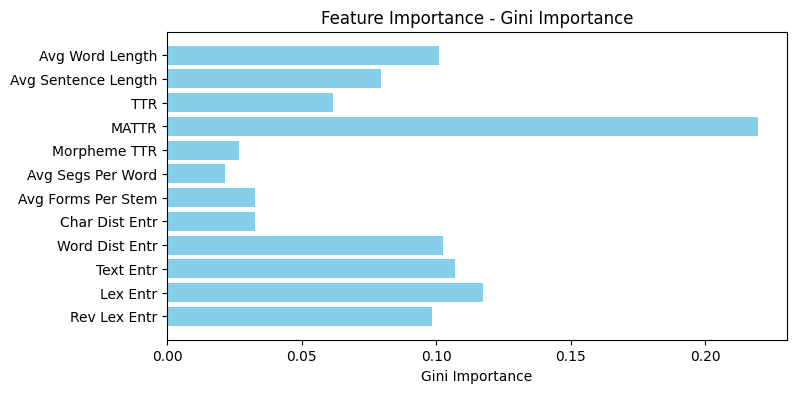

In [9]:
# Plotting feature importance for Finetuned RandomForest (refer to https://www.geeksforgeeks.org/feature-importance-with-random-forests/)

importances = best_rf.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': data.columns[2:].values, 'Gini Importance': importances}).sort_values('Gini Importance', descending=True) 
print(feature_imp_df)

plt.figure(figsize=(8, 4))
plt.barh(data.columns[2:].values, importances, color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()
plt.savefig('./results/RF_gini_feature_importances.png')
plt.show()

                Feature  Permutation Importance
3                 MATTR                0.037500
0       Avg Word Length                0.020833
1   Avg Sentence Length                0.000000
2                   TTR                0.000000
4          Morpheme TTR                0.000000
5     Avg Segs Per Word                0.000000
6    Avg Forms Per Stem                0.000000
7        Char Dist Entr                0.000000
8        Word Dist Entr                0.000000
9             Text Entr                0.000000
10             Lex Entr                0.000000
11         Rev Lex Entr                0.000000


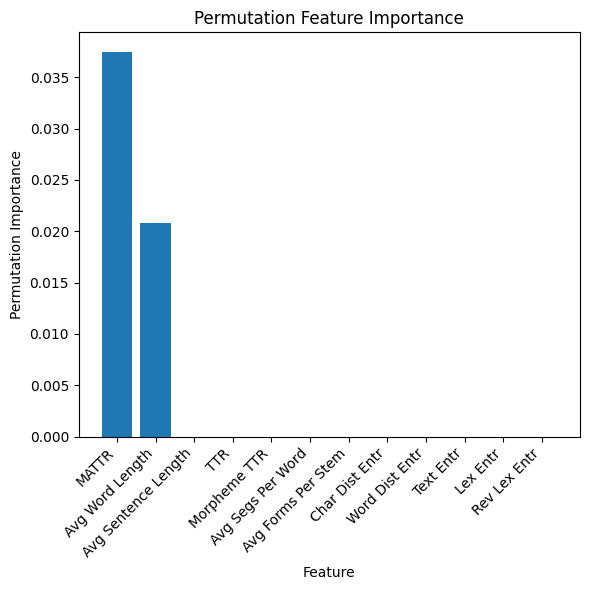

In [10]:
# Plotting permutation feature importance for Finetuned RandomForest (refer to https://www.geeksforgeeks.org/feature-importance-with-random-forests/)

result = permutation_importance(best_rf, X, y, n_repeats=10, random_state=42, n_jobs=-1)
perm_imp_df = pd.DataFrame({'Feature': data.columns[2:].values, 'Permutation Importance': result.importances_mean}).sort_values('Permutation Importance', descending=True)
print(perm_imp_df)

plt.figure(figsize=(6, 6))
plt.bar(perm_imp_df['Feature'], perm_imp_df['Permutation Importance'])
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.title('Permutation Feature Importance')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.savefig('./results/RF_permutation_feature_importances.png')
plt.show()

Binary Classification (SVM)

In [7]:
# With linear kernel

X, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'con':0, 'nat':1}).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    # 'class_weight': ['balanced', {0: 1, 1: 3}, {0: 1, 1: 4}]
    'class_weight': ['balanced']
}

svc = SVC(kernel='linear', random_state=42)
skf = StratifiedKFold(n_splits=12, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='f1', cv=skf, verbose=1)

grid_search.fit(X_train_scaled, y_train)
print("Best parameters found by grid search:", grid_search.best_params_)

best_svc = grid_search.best_estimator_
y_pred = best_svc.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=['con', 'nat'])

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Fitting 12 folds for each of 16 candidates, totalling 192 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=12.
  warnings.warn(


Best parameters found by grid search: {'C': 0.0001, 'class_weight': 'balanced', 'gamma': 'scale'}
Accuracy: 0.60
Confusion Matrix:
 [[1 0]
 [2 2]]
Classification Report:
               precision    recall  f1-score   support

         con       0.33      1.00      0.50         1
         nat       1.00      0.50      0.67         4

    accuracy                           0.60         5
   macro avg       0.67      0.75      0.58         5
weighted avg       0.87      0.60      0.63         5

